In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import warnings
warnings.filterwarnings("ignore")

#matplotlib.use('agg')

In [2]:
#titulo_short = 'NH'
#titulo = 'Northern hemisphere'

titulo_short = 'GO'
titulo = 'Global Ocean'

#titulo_short = 'SH'
#titulo = 'Southern hemisphere'

In [3]:
Ylabel  = 'Temperatura [($^\circ$C)]'
Xlabel  = 'Fecha'

Title1  = 'Temperatura superficial promedio en el '+ titulo
File1 = './images/sstd_mean_'+titulo_short+'.png'
    
Title2  = 'Anomalia de temperatura superficial promedio en el '+ titulo + '\nAnomalia respecto de 1982-1992'
File2 = './images/sstd_anom_mean_'+titulo_short+'.png'
    
Title3  = 'Temperatura superficial en el '+ titulo
File3 = './images/sstd_'+titulo_short+'.png'

Title4  = 'Anomalia de temperatura superficial, respecto del periodo 1982-1992, en el '+ titulo
File4 = './images/sstd_anom_'+titulo_short+'.png'

## Reading data

In [4]:
# Daily data
data = xr.open_dataset('./data/sstd_mean_'+titulo_short+'.nc')
sstd = data.sst
data = xr.open_dataset('./data/sstd_anom_mean_'+titulo_short+'.nc')
sstd_anom = data.sst

In [5]:
#Monthly data
data = xr.open_dataset('./data/sstm_mean_'+titulo_short+'.nc')
sstm= data.sst
data = xr.open_dataset('./data/sstm_anom_mean_'+titulo_short+'.nc')
sstm_anom = data.sst

## Funciones

In [15]:
def FiguraSerieTemporal(sst,Ylabel,Xlabel,TituloFigura,FileOut,Ymin,Ymax):
## Serie temporal anotada con valores maximos y minimos

    dTText = .12
    
    sst_rolling = sst.rolling(time = 360 , center = True).mean()
    
    tmax = sst.isel(sst.argmax(...))
    tmin = sst.isel(sst.argmin(...))
    
    d_tmax = sst.time.isel(sst.argmax(...))
    d_tmin = sst.time.isel(sst.argmin(...))
    

    #Linear fit
    ind = np.isfinite(sst)
    z = np.polyfit(sst.time.astype(np.int64)[ind],sst[ind], 1)
    Dlinearf = z[0] * sst.time.astype(np.int64) + z[1]
    Dslope=z[0]/1.e-9*24*3600*365*100 #paso a C por siglo
    tTendencia =  "\n Tendencia: " + "%2.2f"%(Dslope) + " ºC/siglo "

    fig, ax = plt.subplots(1 , 1 , figsize = (14,8))
    ax.plot(sst.time , sst,'c' , label = 'Diario')
    ax.plot(sst_rolling.time , sst_rolling,'b', label='Suavizado (1 año)' , linewidth = '3')
    ax.plot(sst.time,Dlinearf,'b:',linewidth=2,label = 'Tendencia');
    
    ax.plot(d_tmax , tmax,'rs' , markersize = 12 , markeredgecolor='k')
    ax.plot(d_tmin , tmin,'bs' , markersize = 12 , markeredgecolor='k')

    
    ax.legend(loc = 4)

    tTActual = sst.time[-1].dt.strftime("%d %B %Y").values + " %2.2f ºC "%(sst[-1].values)
    tTMaxima =  'Temperatura máxima: ' + "%2.2f ºC"%(tmax) + ' el ' + d_tmax.dt.strftime("%d %B %Y").values
    tTMinima =  'Temperatura mínima: ' + "%2.2f ºC"%(tmin) + ' el ' + d_tmin.dt.strftime("%d %B %Y").values
    tPeriodo =  " [" + sstd.time[0].dt.strftime("%d %B %Y").values + " - "+ sstd.time[-1].dt.strftime("%d %B %Y").values + "]"

    ax.set_title(TituloFigura + tPeriodo + '\n' + tTMaxima + ' - ' + tTMinima + tTendencia);

    ax.text(sst.time[0] , math.floor(ax.get_ylim()[1]*10)/10 , tTActual, va = 'center',
                bbox={'facecolor':'white', 'edgecolor':'none', 'pad':10},size=14)

    ax.grid(linestyle='-', linewidth=.9)
    ax.set_ylabel(Ylabel)
    ax.set_xlabel(Xlabel)
    ax.set_frame_on(False)
    plt.savefig(FileOut)
    
#----def FiguraSerieTemporal

In [20]:
def FiguraSerieTemporal_anual(sst,Ylabel,Xlabel,TituloFigura,FileOut,Ymin,Ymax):
# Serie temporal por años    

    dTText = .2
    
    df         = sst.groupby(sst.time.dt.dayofyear).mean().to_dataframe(name="mean")
    df["std"]  = sst.groupby(sst.time.dt.dayofyear).std().values

    for year, yearda in sst.groupby(sst.time.dt.year):
        df[year] = pd.Series(index=yearda["time"].dt.dayofyear,
                             data=yearda.values)
    
    df.index   = pd.date_range(start='01/Jan/2020', end='31/12/2020', freq='D')  

    currentYear = datetime.date.today().year
    indLastData = np.where(df[currentYear].isnull())[0].tolist()[0]-1

    date_form = DateFormatter("1-%b")
    
    #Figura
    fig, ax = plt.subplots(figsize=(14,8))

    ax.plot(df.index,df[currentYear],'b',linewidth='3',label=currentYear)
    for year in range(currentYear-4,1981,-1):
        ax.plot(df.index,df[year],color='#D3D3D3')

    for year in range(currentYear-1,currentYear-4,-1):
        ax.plot(df.index,df[year],label=year)

        
    ax.plot(df.index,df[1982],label='1982')

    ax.plot(df.index[indLastData],df[currentYear][indLastData],'bo', markersize=12)
    ax.plot(df.index,df["mean"],'k',linewidth='3',label='mean')
    ax.fill_between(x=df.index, y1=df["mean"]+2*df["std"], 
                            y2=df["mean"]-2*df["std"],alpha=0.5, color='#D3D3D3',
                            label='1.5*std')
    
    ax.set_xlim(df.index[0],df.index[365])
    ax.xaxis.set_major_formatter(date_form)

    ax.legend(loc = 4)
    ax.grid(linestyle='-', linewidth=.9)

    tPeriodo = ' ['+sst.time[0].dt.strftime("%d %B %Y").values + " - "+ sst.time[-1].dt.strftime("%d %B %Y").values + ']'
    tTActual = sst.time[-1].dt.strftime("%d %B %Y").values + " %2.2f ºC "%(sst[-1].values)
    tTMaxima = 'Temperatura Máximo: ' + "%2.2f ºC"%(sst.isel(sst.argmax(...)).values)
    tFechaTMaxima = ' el ' + sst.time.isel(sst.argmax(...)).dt.strftime("%d %B %Y").values

    ax.set_title(TituloFigura + tPeriodo +'\n' + tTActual + '. ' + tTMaxima + tFechaTMaxima);


    ax.set_ylabel(Ylabel)
    ax.set_xlabel(Xlabel)
    ax.set_frame_on(False)
    plt.savefig(FileOut)
#---FiguraSerieTemporal_anual

## Times series mean Sea Surface Temperature

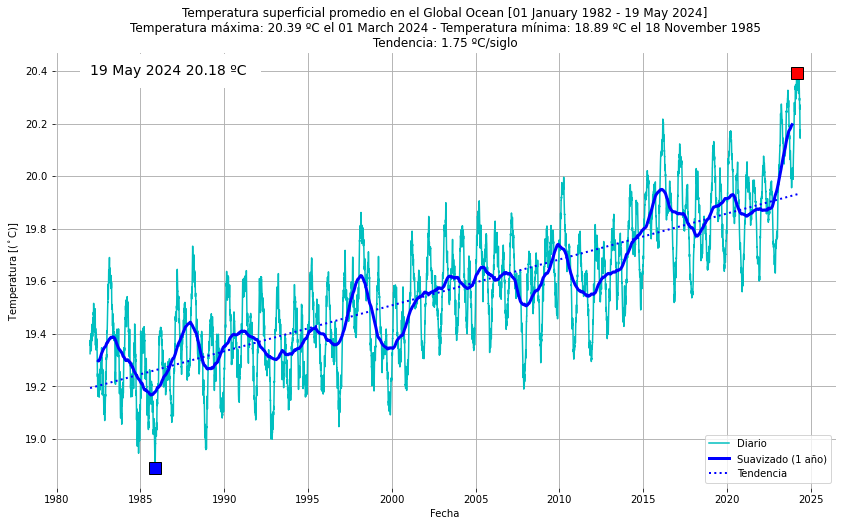

In [17]:
FiguraSerieTemporal(sstd,Ylabel,Xlabel,Title1,File1,18,24)

## Times series mean Sea Surface Temperature anomaly 


 Tendencia: 1.75 ºC/siglo 


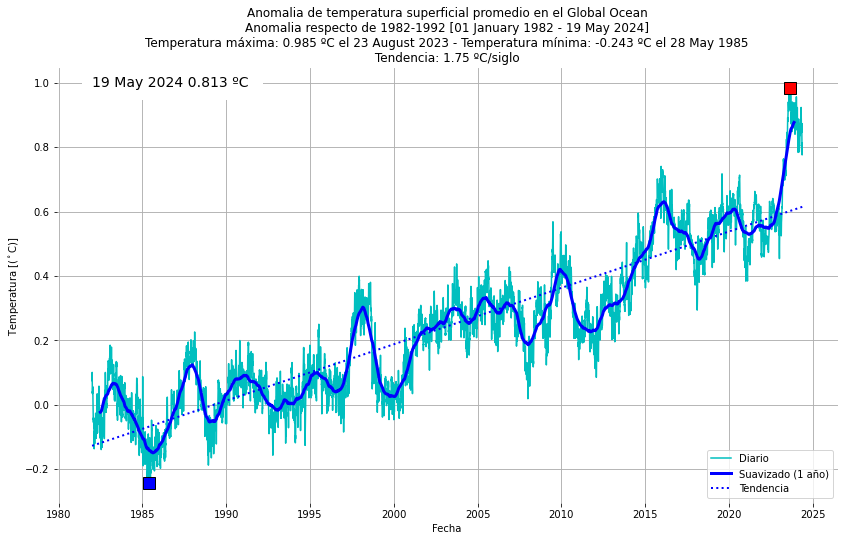

In [13]:
FiguraSerieTemporal(sstd_anom,Ylabel,Xlabel,Title2,File2,-0.25,0.8)

## Daily times series Sea Surface Temperature

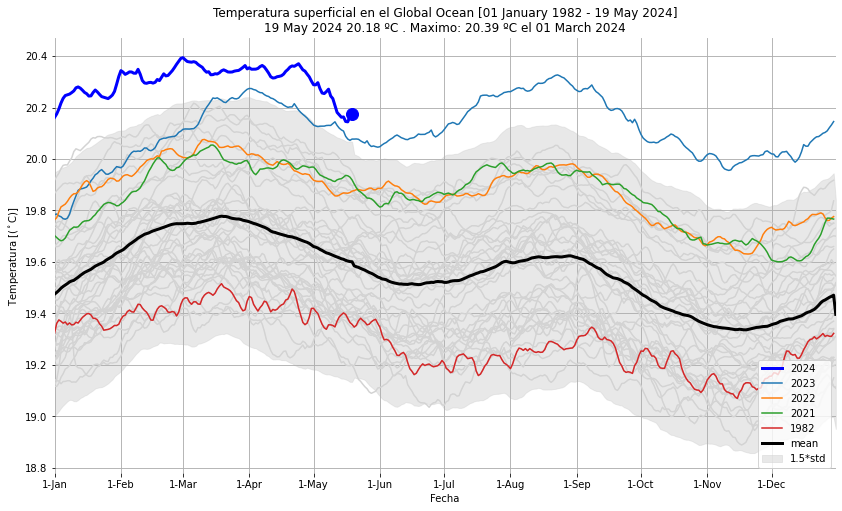

In [18]:
FiguraSerieTemporal_anual(sstd,Ylabel,Xlabel,Title3,File3,17.5,19)

## Daily times series anomly Sea Surface Temperature

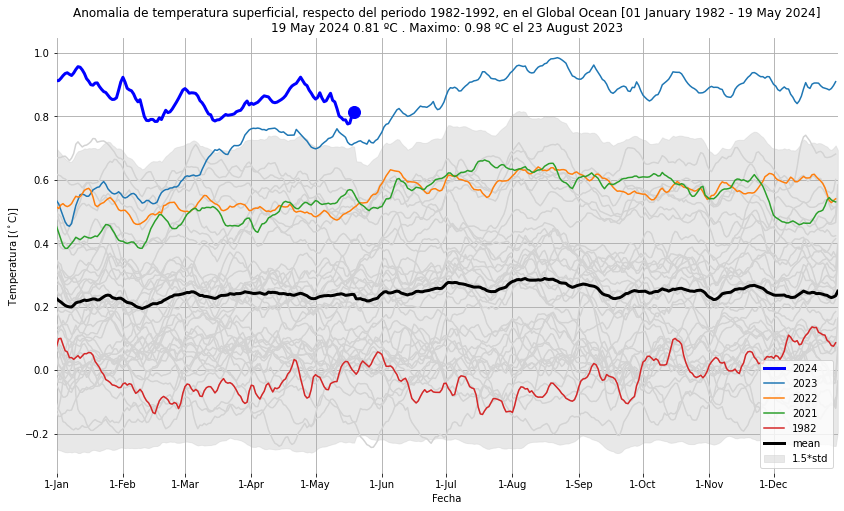

In [19]:
FiguraSerieTemporal_anual(sstd_anom,Ylabel,Xlabel,Title4,File4,-0.25,0.8)